In [2]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
data_instances = [50, 100, 500, 1000, 5000, 10000, 20000, 30000, 36989]
plot_path = Path('/home/user/kew/INSTALLS/fudge/analysis/plots')

mapping = {
#     'file': 'file',
    'test_set': 'Target Level',
    'params': 'Method',
    'sari': 'SARI',
    'bertscore_f1': 'BERTScore',
    'bleu': 'BLEU',
    'fkgl': 'FKGL',
    'intra_dist1': 'Dist-1',
    'ppl': 'PPL',
    'Compression ratio': 'Comp. ratio', 
    'Sentence splits': 'Sent. splits',
    'Levenshtein similarity': 'Lev. sim.',
    'Exact copies': 'Copies', 
    'Additions proportion': 'Add prop.',
    'Deletions proportion': 'Del prop.',
}

In [18]:
sns.set_context('paper')

def check_test_sets(data_path, data_instances=data_instances):
    test_sets = []
    # sanity check - all test sets must be the same for comparison between FUDGEs
    for i, data_count in enumerate(data_instances):
        dataset_pkl = data_path / f'newsela_abl_{data_count}_l4_article_paragraphs' / 'dataset_splts.pkl'
        if dataset_pkl.exists():
            with open(dataset_pkl, 'rb') as f:
                data = pickle.load(f)
                test_sets.append(data['test'])
            if i > 0:
                if data['test'] != test_sets[i-1]:
                    print(f'😱 test sets from data sets for {data_instances[i]} and {data_instances[i-1]} differ!')
                else:
                    print(f'✅ test set from data sets for {data_instances[i]} matches test set for {data_instances[i-1]}')

def read_eval_logs(data_path, data_instances=data_instances):
    
    data = {}
    for i, data_count in enumerate(data_instances):
        eval_file = data_path / f'newsela_abl_{data_count}_l4_article_paragraphs' / 'eval.log'
        if eval_file.exists():
            fudge_id = eval_file.parts[-2].split('_')[2]
            with open(eval_file, 'r', encoding='utf8') as f:
                info = f.read()
                epoch = re.findall('\(epoch (\d+)\)', info)[0]
                eval_line = re.findall('\| EVALUATION \| Epoch 0 \| (.*)', info)[0]
                eval_line = re.sub(' = ', ' ', eval_line)
                eval_line = re.sub('pos ratio', 'pos_ratio', eval_line)
                eval_line = eval_line.split(' | ')
                eval_line = {x.split()[0]: float(x.split()[1]) for x in eval_line}
                eval_line.update({'epoch': int(epoch)})
    #             print(eval_line)
                data[fudge_id] = eval_line

    return pd.DataFrame.from_dict(data, orient='index')

def plot_fudge_learning_progress(df, title='', outpath=None):
    
    df['file'] = df.index
    df.drop(columns=['epoch', 'pos_ratio'], inplace=True) # drop constants/int values
    dfm = df.melt('file', var_name='cols', value_name='vals')
    dfm
    fig, axes = plt.subplots(1, 1, figsize=(8, 5))
    sns.pointplot(x="file", y="vals", hue='cols', data=dfm, ax=axes)
    axes.set_ylabel(None)
    axes.set_xlabel(None)
    fig.suptitle(title)
    
    if outpath is not None:
        plt.savefig(outpath / f'{title.lower().replace(" ", "_")}.pdf', dpi=300)
        plt.savefig(outpath / f'{title.lower().replace(" ", "_")}.png', dpi=300)
        
    return

def read_results_files(data_path, data_instances=data_instances):
    split = 'test'

    data = []

    # iterate through results csvs
    for i, data_count in enumerate(data_instances):
        # look for results files
        fp = data_path / f'newsela-lp_abl_{data_count}_l4_article_paragraphs' / 'bart_large_muss_mined_en' / f'newsela_abl_{data_count}_l4_article_paragraphs' / f'newsela_manual_v0_v4_{split}' / 'results.csv'
        if fp.exists():
#             print(fp)
    #         with open(fp, 'r', encoding='utf8') as inf:
            mdf = pd.read_csv(str(fp), sep=';', header=0)
            data.append(mdf)

    df = pd.concat(data)
    df['file'] = df['file'].apply(lambda x: x.split('/')[-3].split('_')[2])
    return df    

def plot_metrics(df, title='', outpath=None):
    metrics = df.select_dtypes(include=np.number).columns.tolist()
    metrics.remove('bleu') # added 05.09.22 to simplify output plot
    metrics.remove('bertscore_f1') # added 05.09.22 to simplify output plot
    metrics.remove('ppl_diff')
    metrics.remove('bertscore_p')
    metrics.remove('bertscore_r')
    metrics.remove('Lexical complexity score') # added 05.09.22 to simplify output plot
    metrics.remove('Levenshtein similarity') # added 05.09.22 to simplify output plot
    metrics.remove('Compression ratio') # added 05.09.22 to simplify output plot

    metrics = np.array(metrics)
    metrics = np.reshape(metrics, (2, -1))
    fig, axes = plt.subplots(metrics.shape[0], metrics.shape[1], 
                             figsize=(3*metrics.shape[1], 3*metrics.shape[0]), 
                             sharex=True, 
                             tight_layout=True)

    x_ticks = df['file'].tolist()
    print(x_ticks)
    for i in range(metrics.shape[0]):
        for j in range(metrics.shape[1]):
#             print(metrics[i][j])
            sns.scatterplot(
                x='file', 
                y=metrics[i][j], 
                data=df, 
                ax=axes[i][j],
                # hue=metrics[i][j],
                s=50,
#                 size=metric,
#                 sizes=(50, 120),
                marker='o',
                legend=False,
            )
            
            axes[i][j].set_title(mapping[axes[i][j].get_ylabel()])
            axes[i][j].set_ylabel(None)
            axes[i][j].set_xticks(x_ticks)
            # axes[i][j].set_xlim((0,40000))
            axes[i][j].set_xticklabels(x_ticks, rotation=45, horizontalalignment='center')
            axes[i][j].set_xlabel(None)
    
    fig.suptitle(title)
    
    if outpath is not None:
        outfile = str(outpath / f'{title.lower().replace(" ", "_")}')
        plt.savefig(f'{outfile}.pdf', dpi=300)
        plt.savefig(f'{outfile}.png', dpi=300)
        print(f'saved to {outfile} .pdf / .png')

    return



✅ test set from data sets for 100 matches test set for 50
✅ test set from data sets for 500 matches test set for 100
✅ test set from data sets for 1000 matches test set for 500
✅ test set from data sets for 5000 matches test set for 1000
✅ test set from data sets for 10000 matches test set for 5000
✅ test set from data sets for 20000 matches test set for 10000
✅ test set from data sets for 30000 matches test set for 20000
✅ test set from data sets for 36989 matches test set for 30000
['50', '100', '500', '1000', '5000', '10000', '20000', '30000', '40000']
saved to /home/user/kew/INSTALLS/fudge/analysis/plots/number_of_training_examples_used_to_train_fudge_classifier .pdf / .png


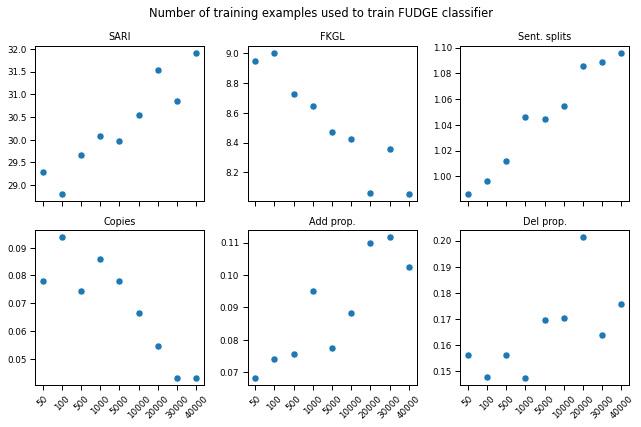

In [19]:
data_path = Path('/srv/scratch6/kew/ats/fudge/discriminators/')
check_test_sets(data_path, data_instances)

# df = read_eval_logs(data_path, data_instances)
# plot_fudge_learning_progress(df, 'Number of training examples used to train FUDGE classifier - Intrinsic', outpath=plot_path)

df = read_results_files(data_path, data_instances)
plot_metrics(df, title='Number of training examples used to train FUDGE classifier', outpath=plot_path)




In [ ]:
# data_path = Path('/srv/scratch6/kew/ats/fudge/discriminators')
# check_test_sets(data_path, data_instances)
# df = read_eval_logs(data_path, data_instances)
# plot_fudge_learning_progress(df, 'Number of training examples used to train a FUDGE - Intrinsic', outpath=plot_path)
# df = read_results_files(data_path, data_instances)
# plot_metrics(df, title='Number of training examples used to train a FUDGE - Extrinsic', outpath=plot_path)